# Structure de bandes électronique du ZrCoBi

In [184]:
from pymatgen.ext.matproj import MPRester
from pymatgen.electronic_structure.plotter import BSPlotter
import matplotlib.pyplot as plt
import numpy as np

In [185]:
#Téléchargement de la structure
with MPRester("CEEbAW2taTmupi7NIXR") as m:
    band = m.get_bandstructure_by_material_id("mp-31451")

# Bande interdite

In [186]:
band_gap = band.get_band_gap()

direct = band_gap['direct']
energy = band_gap['energy']
transition = band_gap['transition']

print("La bande d'énergie est-elle directe? " + str(direct)+ "\n")
print("Energie de la bande interdite : " + str(energy) + " [eV] \n")
print("Direction du vecteur d'onde k pour la transition : " + str(transition) + "\n")

La bande d'énergie est-elle directe? False

Energie de la bande interdite : 0.9774000000000003 [eV] 

Direction du vecteur d'onde k pour la transition : L-X



<module 'matplotlib.pyplot' from '/usr/local/lib64/python3.6/site-packages/matplotlib/pyplot.py'>

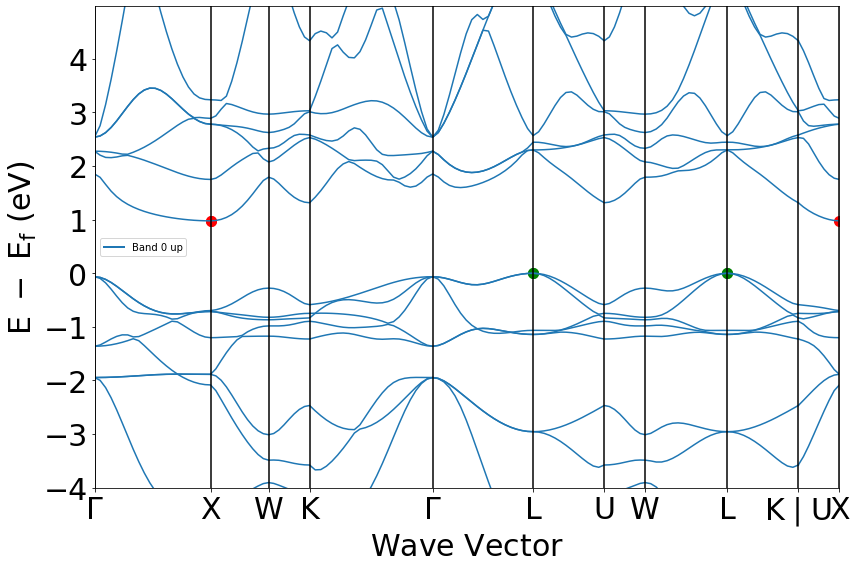

In [187]:
#Visualisation de la bande interdite
bs = BSPlotter(band)
bs.get_plot(vbm_cbm_marker=True)

Conclusions sur la bande interdite : 

Le ZrCoBi a une bande interdite indirecte, on l'observe bien sur le graphe ci-dessus où la transition se fait dans une direction L-X. On voit en effet, qu'en L, on a les maxima de la bande de valence (en vert) et qu'en X, on a les minima de la bande de conduction (en rouge). Comme la différence entre les 2 vecteurs d'onde des deux extrema est non nulle (sur la figure, ils ne se trouvent pas l'un en face de l'autre), on a bien à faire à une bande interdite indirecte.

De plus, l'énergie de cette bande étant de 0.9774 eV, cette valeur est trop petite pour que notre matériau soit un isolant, on peut donc en conclure que que le ZrCoBi est un semi-conducteur. 


# Dispersion

In [188]:
#Récupération des données sur les bandes de valence et conduction
data = bs.bs_plot_data()

#Infos sur les dernières (premières) bandes de valence (de conduction)
vbm = band.get_vbm()
cbm = band.get_cbm()

print("Infos sur les bandes de valences avec maximum :"+ str(vbm['band_index']) + "\n")
print("Infos sur les bandes de conduction avec minimum :"+ str(cbm['band_index']) + "\n")
print("La dernière bande de valence est la bande 12 \n")
print("La première bande de conduction est la bande 13 \n")

Infos sur les bandes de valences avec maximum :defaultdict(<class 'list'>, {<Spin.up: 1>: [11, 12]})

Infos sur les bandes de conduction avec minimum :defaultdict(<class 'list'>, {<Spin.up: 1>: [13]})

La dernière bande de valence est la bande 12 

La première bande de conduction est la bande 13 



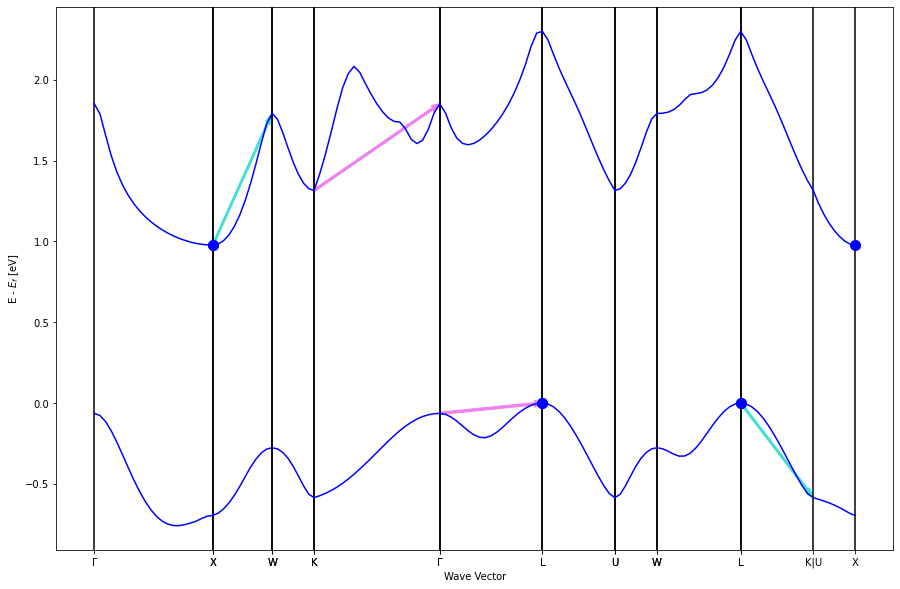

In [189]:
#Affichage de la dispersion

distances = data.get('distances')
energy = data.get('energy')

def slope(x,y):
    slope = abs(y[-1]-y[0])/(x[-1]-x[0])
    return np.array([slope,x[0],y[0],x[-1]-x[0],y[-1]-y[0]])

slope_val = np.zeros((len(distances), 5))
slope_con = np.zeros((len(distances), 5))

for i in range(len(distances)):
    slope_val[i] = slope(distances[i], energy["1"][i][12])
    slope_con[i] = slope(distances[i], energy["1"][i][13])

val_slopes = slope_val.T
con_slopes = slope_con.T

max_val = np.argmax(val_slopes[0])
min_val = np.argmin(val_slopes[0])
max_con = np.argmax(con_slopes[0]) 
min_con = np.argmin(con_slopes[0])

figure,axes = plt.subplots(1,1,figsize=(15,10))

for i in range(len(distance)):
    plt.axvline(distance[i],0,color="black")

for i in range(len(distances)):
    plt.plot(distances[i],energy['1'][i][12],'b')
    plt.plot(distances[i],energy['1'][i][13],'b')
    
for i in range(len(data.get("vbm"))):
    x, y= data.get("vbm")[i]
    plt.plot(x, y, 'ob', markersize=10)
for i in range(len(data.get("cbm"))):
    x, y = data.get("cbm")[i]
    plt.plot(x ,y ,'ob',markersize=10)
    
plt.arrow(val_slopes[1][max_val], val_slopes[2][max_val], val_slopes[3][max_val], val_slopes[4][max_val], color='turquoise', width=0.015, length_includes_head=True)
plt.arrow(val_slopes[1][min_val], val_slopes[2][min_val], val_slopes[3][min_val], val_slopes[4][min_val], color='violet', width=0.015, length_includes_head=True)
plt.arrow(con_slopes[1][max_con], con_slopes[2][max_con], con_slopes[3][max_con], con_slopes[4][max_con], color='turquoise', width=0.015, length_includes_head=True)
plt.arrow(con_slopes[1][min_con], con_slopes[2][min_con], con_slopes[3][min_con], con_slopes[4][min_con], color='violet', width=0.015, length_includes_head=True)

axes.set_xticks(distance)
axes.set_xticklabels(['Γ',"",'X',"","W","",'K',"",'Γ',"","L","",'U',"",'W',"","L",'K|U','X'])
axes.set_xlabel('Wave Vector')
axes.set_ylabel('E - $E_{f}$ [eV]')

plt.show()

Légende : 

Les flèches turquoises représentent les dispersions maximales (quand la pente est maximale) dans les bandes de valence et conduction.
Les flèches roses représentent les dispersions minimales (quand la pente est minimale) dans les bandes de valence et conduction.

Directions des vecteurs d'onde : 
- Dispersion maximale dans les bandes de valence : de X vers W.
- Dispersion minimale dans les bandes de valence : de K vers Γ.
- Dispersion maximale dans les bandes de conduction : de L vers K|U.
- Dispersion minimale dans les bandes de conduction : de Γ vers L.

# Masse effective

La masse effective s'obtient comme tel : m* = ℏ^2/ (∂^2E/∂k^2)

On suit l'hypothèse d'une dispersion parabolique, nous allons donc faire une régression polynomiale de second ordre autour des points désirés afin de trouver la valeur de la masse effective.

In [190]:
#Constante hbar
h_bar = 6.582119570 * 1e-16 # en eV

vbm = data.get('vbm')
cbm = data.get('cbm')

#Interpolation pour la bande de valence
k_val = np.zeros(3)
k_val[1] = vbm[0][0]
k_val[0] = distances[4][-2]
k_val[2] = distances[5][1]

e_val = np.zeros(3)
e_val[1] = vbm[0][1]
e_val[0] = energy.get('1')[4][12][-2]
e_val[2] = energy.get('1')[5][12][1]

interpolation_val = np.polyfit(k_val,e_val,2)

#Calcul de la masse effective
m_val = (vbm[0][0])**2 * (h_bar**2 / (2*interpolation_val[0]))

#Interpolation pour la bande de conduction
k_con = np.zeros(3)
k_con[1] = cbm[0][0]
k_con[0] = distances[0][-2]
k_con[2] = distances[2][1]

e_con = np.zeros(3)
e_con[1] = cbm[0][1]
e_con[0] = energy.get('1')[0][13][-2]
e_con[2] = energy.get('1')[2][13][1]

interpolation_con = np.polyfit(k_con,e_con,2)

#Calcul de la masse effective
m_con = (cbm[0][0])**2 * (h_bar**2 / (2*interpolation_con[0]))

#Résultats
print("La masse effective pour la bande de valence est de " + str(m_val) + "kg. \n")
print("La masse effective pour la bande de conduction est de " + str(m_con) + "kg. \n")

La masse effective pour la bande de valence est de -1.4709716526175528e-30kg. 

La masse effective pour la bande de conduction est de 9.050349580159588e-32kg. 

